In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import cv2
import shutil 
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
positive_cases_path=os.path.join('../input/covidct/CT_COVID')
negative_cases_path=os.path.join('../input/covidct/CT_NonCOVID')
print('Positive samples:{}'.format(len(os.listdir(positive_cases_path))))
print('Negative samples:{}'.format(len(os.listdir(negative_cases_path))))
#setting directory path for the input(given dataset from kaggle)dataset.

Positive samples:349
Negative samples:397


In [3]:
positive_CT_images=glob(os.path.join(positive_cases_path,"*.png"))
negative_CT_images=glob(os.path.join(negative_cases_path,"*.png"))
negative_CT_images.extend(glob(os.path.join(negative_cases_path,"*.jpg")))
#glob function to attach all image files present in the respective paths
#(where covid+ve has only png files and covid -ve has png,jpg files)

In [4]:
covid={'class':'Covid_CT','path': positive_cases_path,'images':positive_CT_images}
non_covid={'class':'NonCovid_CT','path':negative_cases_path,'images':negative_CT_images}
#making dictionaries with key as covid +ve and -ve and corresponding list objects of both patha nd images as values

In [5]:
subdirs=['train/','test/']#two directory pathnames
for subdir in subdirs:
    labeldirs=['Covid_CT','NonCovid_CT']#categorical subdirs
    for labeldir in labeldirs:
        newdir=subdir+labeldir 
        os.makedirs(newdir,exist_ok='True')

In [6]:
#copy images to test set
random.seed(123)
test_ratio=0.2

for cases in [covid,non_covid]:
    total_cases=len(cases['images'])
    num_to_select=(int)(total_cases*test_ratio)#number of images to copy in test set
    print(num_to_select,total_cases)
    random_files_list=random.sample(cases['images'],num_to_select)#random files selected
    for files in random_files_list:
        shutil.copy(files,'test/'+cases['class'])#copied to the categorical subdir

69 349
79 397


In [7]:
for cases in [covid,non_covid]:
    images_test_files=os.listdir('test/'+cases['class'])#list of test files 
    for images in cases['images']:
        if images.split('/')[-1] not in images_test_files:#files except those in the test directory are added to train
            shutil.copy(images,'train/'+cases['class'])

In [8]:
total_train_covid = len(os.listdir('/kaggle/working/train/Covid_CT'))
total_train_noncovid = len(os.listdir('/kaggle/working/train/NonCovid_CT'))
total_test_covid = len(os.listdir('/kaggle/working/test/Covid_CT'))
total_test_noncovid = len(os.listdir('/kaggle/working/test/NonCovid_CT'))

print("Train sets images COVID: {}".format(total_train_covid))
print("Train sets images Non COVID: {}".format(total_train_noncovid))
print("Test sets images COVID: {}".format(total_test_covid))
print("Test sets images Non COVID: {}".format(total_test_noncovid))

Train sets images COVID: 280
Train sets images Non COVID: 318
Test sets images COVID: 69
Test sets images Non COVID: 79


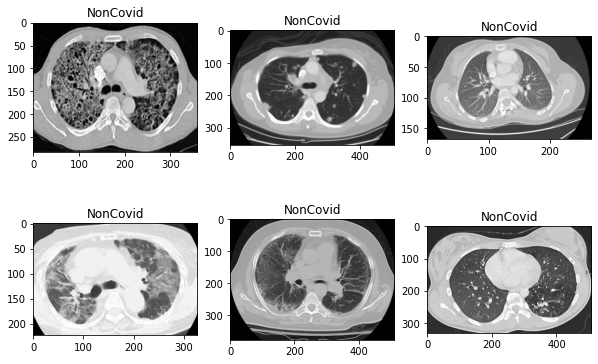

In [9]:
from os import listdir
listdir()
NCovid_train='/kaggle/working/train/NonCovid_CT'
train_images_NC=listdir(NCovid_train)
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(os.path.join(NCovid_train,train_images_NC[i])),cmap='gray')
    plt.title('NonCovid')
plt.show()

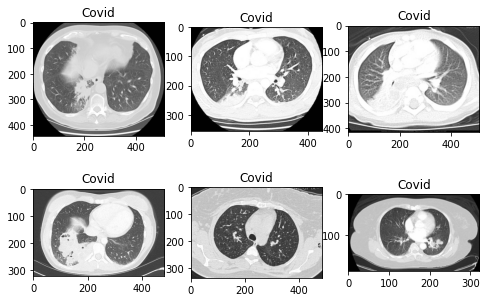

In [10]:
plt.figure(figsize=(8,8))
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.imshow(cv2.imread(os.path.join(negative_CT_images[i])))
    plt.title('Covid')
plt.show()

In [11]:
#train_datagen=ImageDataGenerator(rescale=1/255.0,rotation_range=30,width_shift_range=0.2,
                                #height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,
                                #horizontal_flip=True,vertical_flip=True)
train_datagen=ImageDataGenerator(rescale=1/255.0)
test_datagen=ImageDataGenerator(rescale=1/255.0)

In [12]:
train_dir=os.path.join('/kaggle/working/train/')
test_dir=os.path.join('/kaggle/working/test/')

image_shape=200

train_generator=train_datagen.flow_from_directory(train_dir,
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 target_size=(image_shape,image_shape))

test_generator=test_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               class_mode='binary',
                                               target_size=(image_shape,image_shape))
                                                 

Found 598 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [13]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(200,200,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0

In [15]:
model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

batch_size=32
history=model.fit(train_generator,steps_per_epoch = train_generator.samples // batch_size,
    epochs=10,validation_data=test_generator)

Epoch 1/10
18/18 [==============================] - 15s 810ms/step - loss: 0.8868 - accuracy: 0.5128 - val_loss: 0.6922 - val_accuracy: 0.5270
Epoch 2/10
18/18 [==============================] - 13s 739ms/step - loss: 0.6905 - accuracy: 0.5322 - val_loss: 0.6833 - val_accuracy: 0.6014
Epoch 3/10
18/18 [==============================] - 13s 739ms/step - loss: 0.6755 - accuracy: 0.5958 - val_loss: 0.6854 - val_accuracy: 0.5405
Epoch 4/10
18/18 [==============================] - 13s 728ms/step - loss: 0.6744 - accuracy: 0.6616 - val_loss: 0.6638 - val_accuracy: 0.5405
Epoch 5/10
18/18 [==============================] - 13s 719ms/step - loss: 0.6634 - accuracy: 0.6004 - val_loss: 0.6152 - val_accuracy: 0.6689
Epoch 6/10
18/18 [==============================] - 13s 742ms/step - loss: 0.6411 - accuracy: 0.6412 - val_loss: 0.5996 - val_accuracy: 0.6757
Epoch 7/10
18/18 [==============================] - 13s 729ms/step - loss: 0.5748 - accuracy: 0.7058 - val_loss: 0.5987 - val_accuracy: 0.6216

In [16]:
model.evaluate(test_generator)

5/5 [==============================] - 1s 198ms/step - loss: 0.5635 - accuracy: 0.6622


[0.5635198950767517, 0.662162184715271]

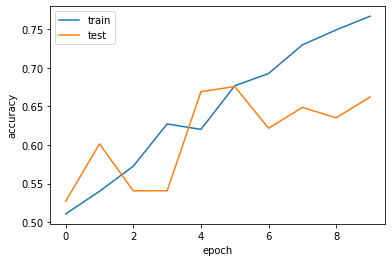

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

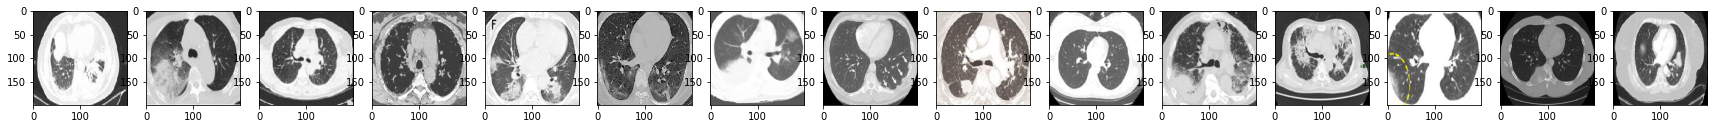

[1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1.
 0. 1. 0. 1. 1. 0. 1. 0.] {'Covid_CT': 0, 'NonCovid_CT': 1}


In [18]:
imgs,labels=next(test_generator)
fig,axes=plt.subplots(1,15,figsize=(30,30))
for im,ax in zip(imgs,axes):
    ax.imshow(im)
plt.show()
print(labels,test_generator.class_indices)

In [19]:
from sklearn.metrics import confusion_matrix
step_size=test_generator.samples//test_generator.batch_size
test_generator.reset()
Y_Pred=model.predict_generator(test_generator,steps=step_size)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [20]:
predictions=[]
y_pred=[]
for pred in Y_Pred:
    if pred<=0.5:
        predictions.append('Covid_CT')
        y_pred.append(0)
    else:
        predictions.append('NonCovid_CT')
        y_pred.append(1)
filenames=[]
classnames=[]
for i in range(128):
    filenames.append(test_generator.filenames[i])
    classnames.append(test_generator.classes[i])

In [21]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(classnames,y_pred))

[[31 38]
 [18 41]]


In [22]:
model.save_weights("CT_model.h5")